In [1]:
library(tidyverse)
library(caret)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: lattice

Attaching package: ‘caret’

The following object is masked from ‘package:purrr’:

    lift



# Generate Simulated Data Set

In [2]:
library(tidyverse)
library(caret)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: lattice

Attaching package: ‘caret’

The following object is masked from ‘package:purrr’:

    lift



In [10]:
## Functions used to generate fake data
set.seed(42)
f_fried <- function(x) 10 * sin(pi * x[,1] * x[,2]) + 20 * (x[,3] - 0.5)^2 + 
  10 * x[,4] + 5 * x[,5]

our_function <- function(x) sin(x[,1])*exp(x[,2])*10 + cos(2*x[,3]) - 20*x[,4]^2 + 3*x[,5]^3 - 15*x[,6]^(1/3) 

high_dimensional_func <- function(x) 10 * sin(pi * apply(x[,1:100], 1, prod)) + 20 * (apply(x[,101:150],1,sum) - 5)^2 + 
  10 * apply(x[,151:200],1,sum) + 5 * apply(x[,201:250],1,sum)

gen_data <- function(n_train, n_test, func, P, sigma, a, b) {
  X <- matrix(runif(n_train * P, a, b), nrow = n_train)
  mu <- func(X)
  X_test <- matrix(runif(n_test * P, a, b), nrow = n_test)
  mu_test <- func(X_test)
  Y <- mu + sigma * rnorm(n_train)
  Y_test <- mu_test + sigma * rnorm(n_test)
  
  return(list(X = X, Y = Y, mu = mu, X_test = X_test, Y_test = Y_test, mu_test = mu_test))
}


## Simulate datasets
set.seed(42)
#all 5 predictors are important
sim_data_usual <- gen_data(250, 100, f_fried, 10, 1, 0, 1)
sim_data <- sim_data_usual

In [6]:
sim_data$X %>% head
sim_data$Y %>% head

0.9148060,0.33423133,0.1365052,0.24492099,0.84829322,0.73592037,0.05391100,0.1651787,0.9899656,0.24640458
0.9370754,0.18843433,0.1771364,0.08763591,0.06274633,0.75178575,0.95509577,0.7277811,0.4384936,0.02302811
0.2861395,0.26971618,0.5195605,0.39110850,0.81984509,0.33261448,0.02560094,0.2061579,0.6999032,0.28421418
0.8304476,0.53074408,0.8111208,0.18256143,0.53936029,0.05754862,0.92076314,0.5864655,0.8890770,0.81289268
0.6417455,0.02145023,0.1153620,0.13362478,0.49902010,0.67441545,0.36666474,0.9135460,0.8341595,0.71891839
0.5190959,0.79876031,0.8934218,0.25746291,0.02222732,0.04157017,0.69839255,0.2069666,0.7344215,0.52957674


[1] 16.684631  7.580189 10.429897 17.500578  6.333721 15.642008

# BART with 5 Predictors

In [2]:
options(java.parameters = "-Xmx8g")
library(bartMachine)

Loading required package: rJava
Loading required package: bartMachineJARs
Loading required package: car
Loading required package: carData

Attaching package: ‘car’

The following object is masked from ‘package:dplyr’:

    recode

The following object is masked from ‘package:purrr’:

    some

Loading required package: randomForest
randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:dplyr’:

    combine

The following object is masked from ‘package:ggplot2’:

    margin

Loading required package: missForest
Loading required package: foreach

Attaching package: ‘foreach’

The following objects are masked from ‘package:purrr’:

    accumulate, when

Loading required package: itertools
Loading required package: iterators
Welcome to bartMachine v1.2.3! You have 7.64GB memory available.

If you run out of memory, restart R, and use e.g.
'options(java.parameters = "-Xmx5g")' for 5GB of RAM b

In [8]:
#Include the parallel library. If the next line does not work, run install.packages(“parallel”) first
library(parallel)
library(doParallel)

# Use the detectCores() function to find the number of cores in system
n_cores <- detectCores()
print(n_cores)
cl <- makePSOCKcluster(n_cores)
#registerDoParallel(cl)
#stopCluster(cl)

[1] 16


In [9]:
set_bart_machine_num_cores(n_cores)

bartMachine now using 16 cores.


In [10]:
t.start <- Sys.time()
sim.bm <- bartMachine(X = sim_data$X %>% data.frame, y = sim_data$Y,
            verbose = TRUE, 
            serialize =  TRUE)
t.final <- Sys.time() - t.start
print(t.final)

bartMachine initializing with 50 trees...
bartMachine vars checked...
bartMachine java init...
bartMachine factors created...
bartMachine before preprocess...
bartMachine after preprocess... 11 total features...
bartMachine sigsq estimated...
bartMachine training data finalized...
Now building bartMachine for regression ...
evaluating in sample data...done
serializing in order to be saved for future R sessions...done
Time difference of 2.964943 secs


In [27]:
k_fold_cv(X = sim_data$X %>% data.frame, y = sim_data$Y,)

.....


$y_hat
  [1] 16.603835  8.752994 10.607553 16.570941  7.208765 15.182139 11.378538
  [8] 10.073789 21.652226 24.211808 21.703893 15.091393 10.571256  9.544188
 [15] 15.409186 14.478291 17.303908  6.696955 16.965234 14.908000 14.994571
 [22]  7.716244 15.145312  8.079156 11.016082  8.421424 20.795178 20.504079
 [29] 18.502550 24.208854 22.857201 11.871630  7.825377 10.967210  8.071398
 [36] 10.178962 11.295145 10.740317 13.918845  2.329992 21.937012 17.234145
 [43]  8.842226 14.187675 14.749321  7.386506 18.448532 15.518659 15.718353
 [50]  4.176374 20.923133 17.666340  3.535403 18.884472 12.498924 16.541092
 [57] 18.876940  7.383069  9.200878 12.792381  7.341254 23.308288 18.204162
 [64] 11.152183 15.435686 16.528632 17.603333 12.427412 11.551132 16.161962
 [71]  6.692171 11.943352 10.104075 13.496573  7.524702 21.088499 10.326105
 [78] 12.352935 12.116620  3.274598 15.643075 11.957405  4.397176 14.796152
 [85] 20.165542 14.984322 17.261238 13.705801 15.566438  5.108857 19.472483
 [92]  8.191903  9.107334 19.588814 10.950861  5.329799 12.781475 11.014900
 [99] 25.069871 14.201117 13.727429 17.596447  8.514819  8.935715 15.534013
[106] 11.469758 20.773534 20.857452 14.473440 14.299061 20.383761 17.280354
[113] 14.006724 16.300318 14.501354 21.160215  7.560779 15.866412 12.245659
[120] 15.588380 12.665177 17.959746 14.469186 13.040347 19.312907 20.346178
[127] 10.263482 10.202417 12.137285 16.371795 17.420520 19.795250 18.843645
[134] 17.098289 20.953655 14.724309  9.551341  4.208993 17.698924 13.757919
[141]  9.507063 11.996713 16.564209 15.548465 12.495375 19.472107 10.093232
[148] 10.382974 18.747069 10.059495  8.192559 10.717966 20.473380 11.491220
[155] 16.350858 17.970108 12.883215  7.233858  8.708498  9.919243 10.973182
[162] 17.683101 16.747351 18.902683 11.586630 10.788316 15.504833 14.124251
[169] 10.473578  3.548314 11.406891 22.070275 24.837939 12.936595 16.311133
[176] 11.570908 13.912803 15.883713 14.424011 18.480332 17.600790 24.010400
[183] 18.509159 14.137045 21.950490  8.286252 13.380367 13.649224  5.780658
[190] 17.266723 12.317421 17.773953  5.676347 10.109787 15.382678  9.233915
[197]  3.412509 13.415122 21.492364  5.419541 15.760351 12.974786 18.875578
[204] 17.696111 12.222429 18.845390 18.016404 19.267606 14.170480 17.980012
[211] 19.213944 17.495289  7.783811 10.154242  7.667795 22.007257  7.735159
[218]  9.094001 17.620071 15.297922 12.645316  8.977385 20.472305 15.986455
[225] 11.454666 16.678563 12.097485  9.786604 10.024182  9.990436 11.978584
[232]  7.169197 15.634346 13.643625 18.165484 14.111750 16.675392  9.869825
[239]  8.568538 12.649972 17.184098 10.944363 13.586630 19.291286 12.725055
[246]  8.419232 16.589205  8.652582 11.624110  6.002431

$L1_err
[1] 304.1632

$L2_err
[1] 626.2826

$rmse
[1] 1.58276

$PseudoRsq
[1] 0.9039155

$folds
  [1] 5 5 4 3 2 1 1 4 2 1 3 4 4 5 2 2 1 2 2 4 5 1 4 5 5 2 4 4 5 5 3 5 4 4 2 2 4
 [38] 3 1 1 5 4 1 4 4 5 5 2 5 3 2 4 5 5 3 1 1 3 4 3 1 2 1 3 2 4 2 1 2 3 1 2 1 5
 [75] 3 1 3 3 1 5 5 4 5 2 1 2 4 1 5 4 4 4 5 1 2 3 5 5 3 2 3 3 1 1 3 1 4 1 2 1 2
[112] 4 5 2 5 5 2 3 1 3 5 3 2 3 3 3 3 2 3 1 2 4 3 3 3 5 1 1 3 2 2 4 5 5 2 5 5 4
[149] 5 2 2 4 4 3 4 1 2 2 4 2 3 3 5 2 2 4 4 1 2 1 5 5 4 3 3 2 2 4 2 4 5 5 4 1 3
[186] 5 3 4 3 1 4 1 5 3 3 4 5 1 4 5 3 2 5 2 1 2 3 1 4 1 1 1 3 4 2 2 3 3 5 1 5 3
[223] 1 2 4 5 5 2 4 1 3 1 1 4 2 1 3 5 4 3 3 4 4 5 1 1 2 4 5 1

In [12]:
sim.bm %>% summary

bartMachine v1.2.3 for regression

training data n = 250 and p = 10 
built in 2.3 secs on 16 cores, 50 trees, 250 burn-in and 1000 post. samples

sigsq est for y beforehand: 6.341 
avg sigsq estimate after burn-in: 1.07656 

in-sample statistics:
 L1 = 133.62 
 L2 = 116.24 
 rmse = 0.68 
 Pseudo-Rsq = 0.9822
p-val for shapiro-wilk test of normality of residuals: 0.22263 
p-val for zero-mean noise: 0.26307 



In [13]:
rmse <- function(actual, predicted){
    sqrt(mean((actual-predicted)^2))
}

In [14]:
rmse(sim_data$Y, predict(sim.bm, sim_data$X %>% data.frame)) #insample
rmse(sim_data$Y_test, predict(sim.bm, sim_data$X_test %>% data.frame)) #out of sample

[1] 0.6818773

[1] 1.372524

In [15]:
sim.bm %>% check_bart_error_assumptions

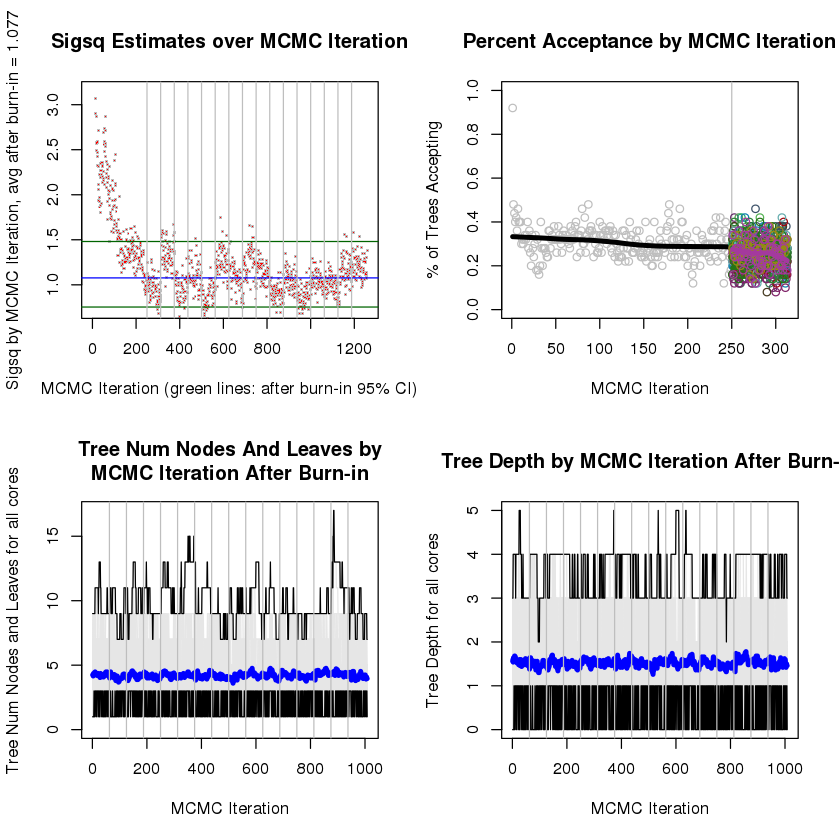

In [16]:
sim.bm %>% plot_convergence_diagnostics

....................


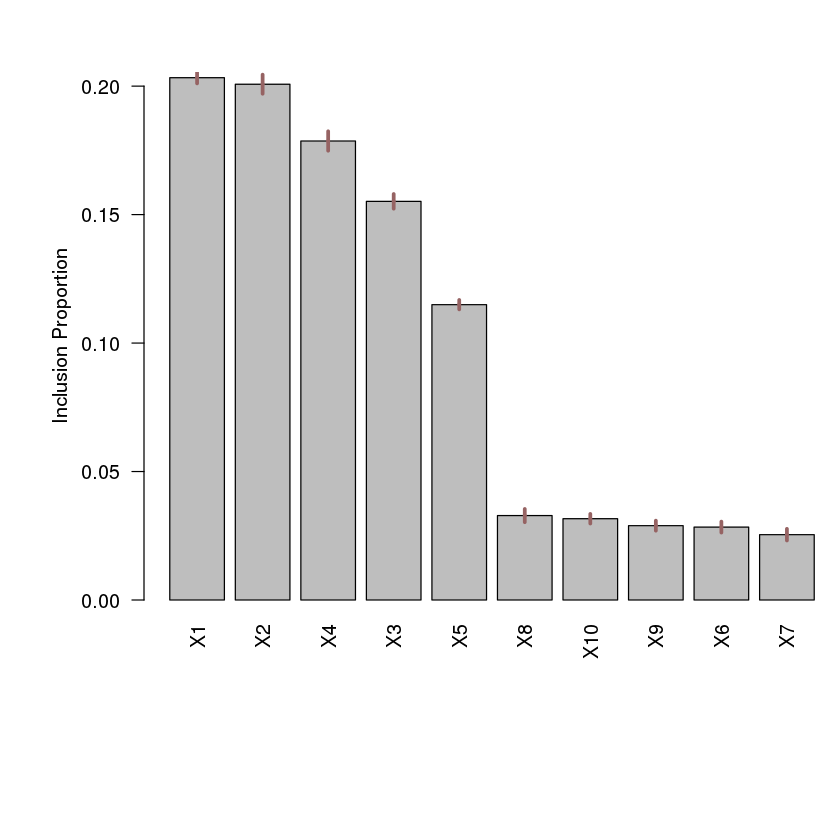

In [17]:
investigate_var_importance(sim.bm, num_replicates_for_avg = 20)

avg..........null....................................................................................................


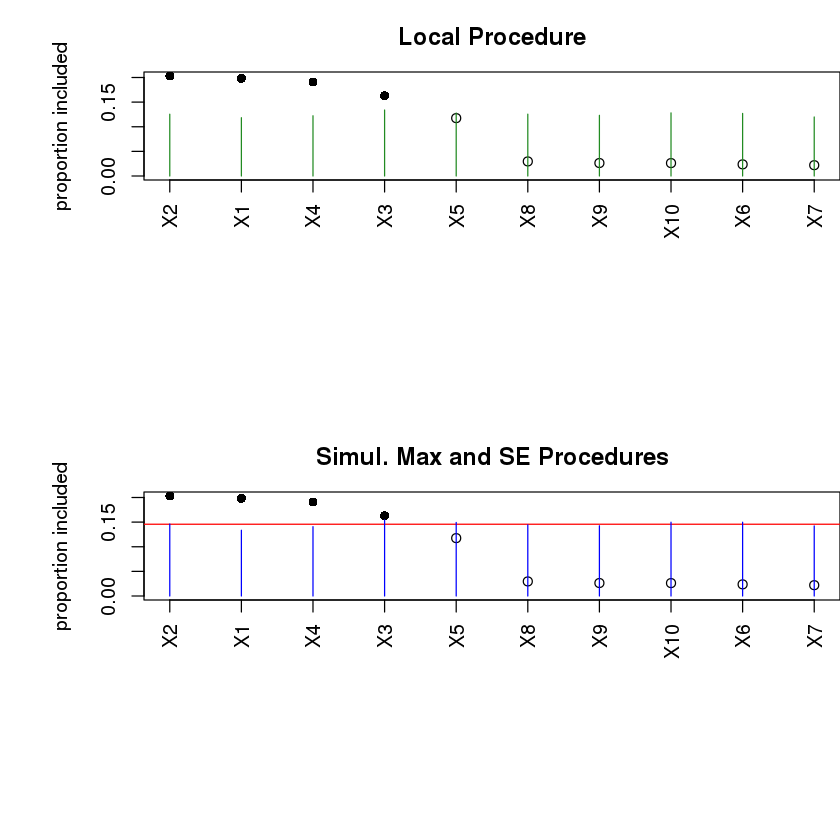

In [5]:
sim.bm %>% var_selection_by_permute(plot = TRUE)

In [4]:
#saveRDS(sim.bm,"model_files/simbm_model_v2_20191126.RDS")
sim.bm.read <- readRDS("model_files/simbm_model_v2_20191126.RDS")
sim.bm <- sim.bm.read

# DART with 5 Predictors

In [4]:
options(java.parameters = "-Xmx8g")
library(dartMachine)

In [5]:
#Include the parallel library. If the next line does not work, run install.packages(“parallel”) first
library(parallel)
library(doParallel)

# Use the detectCores() function to find the number of cores in system
n_cores <- detectCores()
print(n_cores)
cl <- makePSOCKcluster(n_cores)
#registerDoParallel(cl)
#stopCluster(cl)

[1] 16


In [6]:
set_bart_machine_num_cores(n_cores)

bartMachine now using 16 cores.


In [11]:
t.start <- Sys.time()
sim.dartmachine <- bartMachine(X = sim_data$X %>% data.frame, y = sim_data$Y,
            verbose = TRUE, 
            serialize =  TRUE)
t.final <- Sys.time() - t.start
print(t.final)

bartMachine initializing with 50 trees...
Now building bartMachine for regression ...Covariate importance prior ON. 
evaluating in sample data...done
serializing in order to be saved for future R sessions...done
Time difference of 10.69141 secs


In [12]:
sim.dartmachine %>% summary

bartMachine v1.2.0 for regression

training data n = 250 and p = 10 
built in 8.6 secs on 16 cores, 50 trees, 4000 burn-in and 4000 post. samples

sigsq est for y beforehand: 6.341 
avg sigsq estimate after burn-in: 0.76998 

in-sample statistics:
 L1 = 108.22 
 L2 = 76.07 
 rmse = 0.55 
 Pseudo-Rsq = 0.9883
p-val for shapiro-wilk test of normality of residuals: 0.11068 
p-val for zero-mean noise: 0.16271 



In [13]:
rmse <- function(actual, predicted){
    sqrt(mean((actual-predicted)^2))
}

In [14]:
rmse(sim_data$Y, predict(sim.dartmachine, sim_data$X %>% data.frame)) #insample
rmse(sim_data$Y_test, predict(sim.dartmachine, sim_data$X_test %>% data.frame)) #out of sample

[1] 0.5516234

[1] 1.2836

In [15]:
sim.dartmachine %>% check_bart_error_assumptions

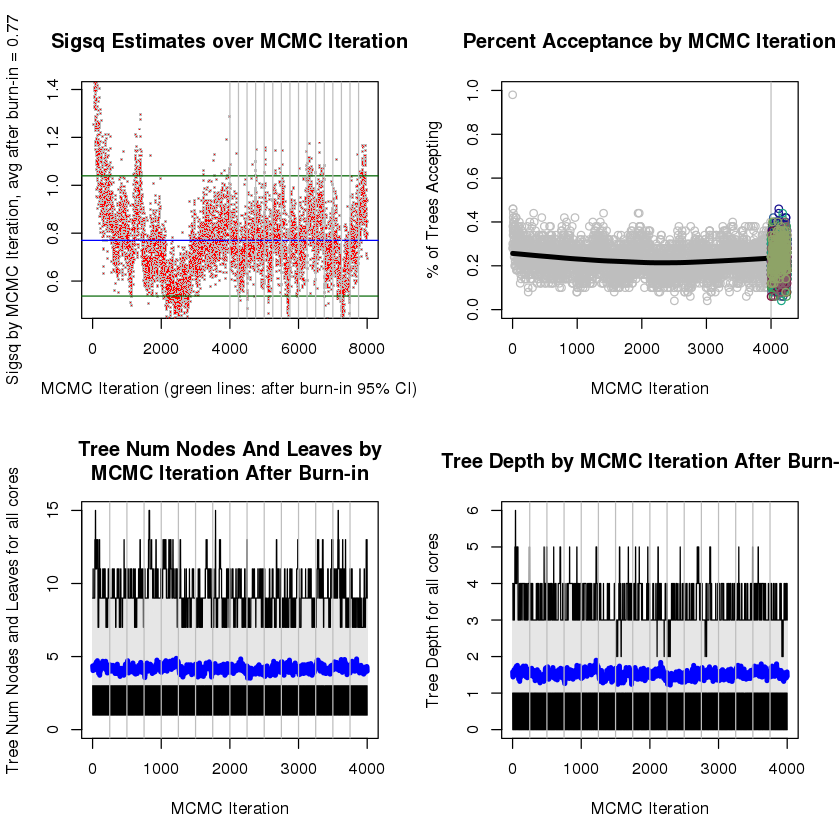

In [16]:
sim.dartmachine %>% plot_convergence_diagnostics

....................


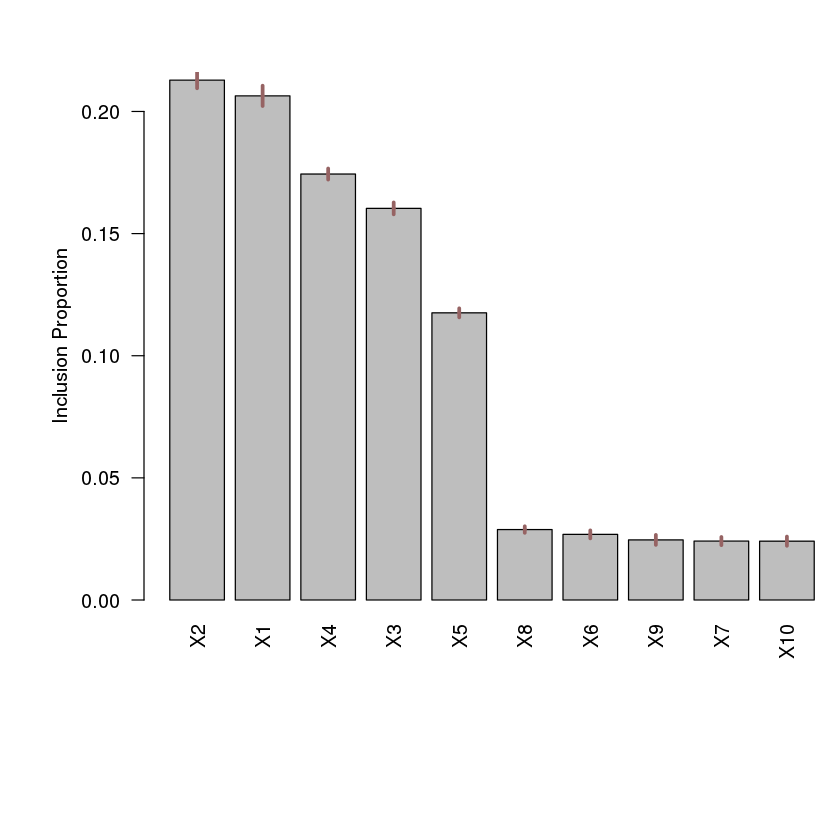

In [17]:
investigate_var_importance(sim.dartmachine, num_replicates_for_avg = 20)

In [18]:
saveRDS(sim.dartmachine,"model_files/simdartMachine_model_v2_20191126.RDS")
sim.dartmachine.read <- readRDS("model_files/simdartMachine_model_v2_20191126.RDS")
sim.dartmachine <- sim.dartmachine.read

# SoftBART

In [19]:
library(SoftBart)

Loading required package: scales

Attaching package: ‘scales’

The following object is masked from ‘package:purrr’:

    discard

The following object is masked from ‘package:readr’:

    col_factor

Loading required package: glmnet
Loading required package: Matrix

Attaching package: ‘Matrix’

The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack

Loaded glmnet 3.0-1

Loading required package: Rcpp


Finishing warmup 100 Number of trees = 50
Finishing warmup 200 Number of trees = 50
Finishing warmup 300 Number of trees = 50
Finishing warmup 400 Number of trees = 50
Finishing warmup 500 Number of trees = 50
Finishing warmup 600 Number of trees = 50
Finishing warmup 700 Number of trees = 50
Finishing warmup 800 Number of trees = 50
Finishing warmup 900 Number of trees = 50
Finishing warmup 1000 Number of trees = 50
Finishing warmup 1100 Number of trees = 50
Finishing warmup 1200 Number of trees = 50
Finishing warmup 1300 Number of trees = 50
Finishing warmup 1400 Number of trees = 50
Finishing warmup 1500 Number of trees = 50
Finishing warmup 1600 Number of trees = 50
Finishing warmup 1700 Number of trees = 50
Finishing warmup 1800 Number of trees = 50
Finishing warmup 1900 Number of trees = 50
Finishing warmup 2000 Number of trees = 50
Finishing warmup 2100 Number of trees = 50
Finishing warmup 2200 Number of trees = 50
Finishing warmup 2300 Number of trees = 50
Finishing warmup 240

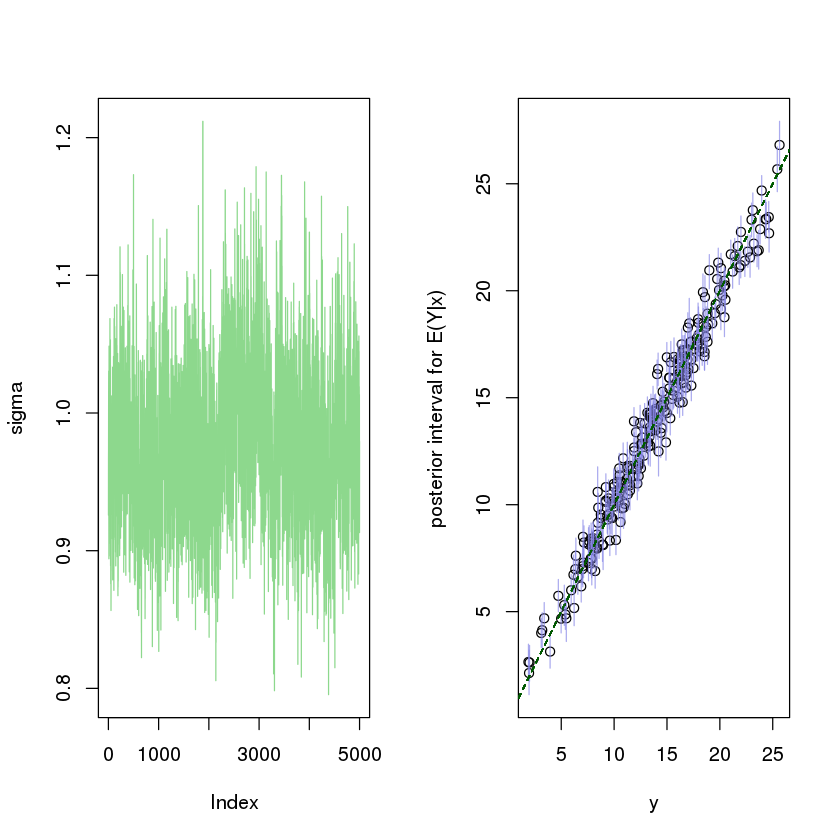

In [20]:
## Fit the models
softbart_fit_1 <- softbart(X = sim_data$X, Y = sim_data$Y, X_test = sim_data$X_test, 
                hypers = Hypers(sim_data$X, sim_data$Y, num_tree = 50, temperature = 1),
                opts = Opts(num_burn = 5000, num_save = 5000, update_tau = TRUE))

plot(softbart_fit_1)

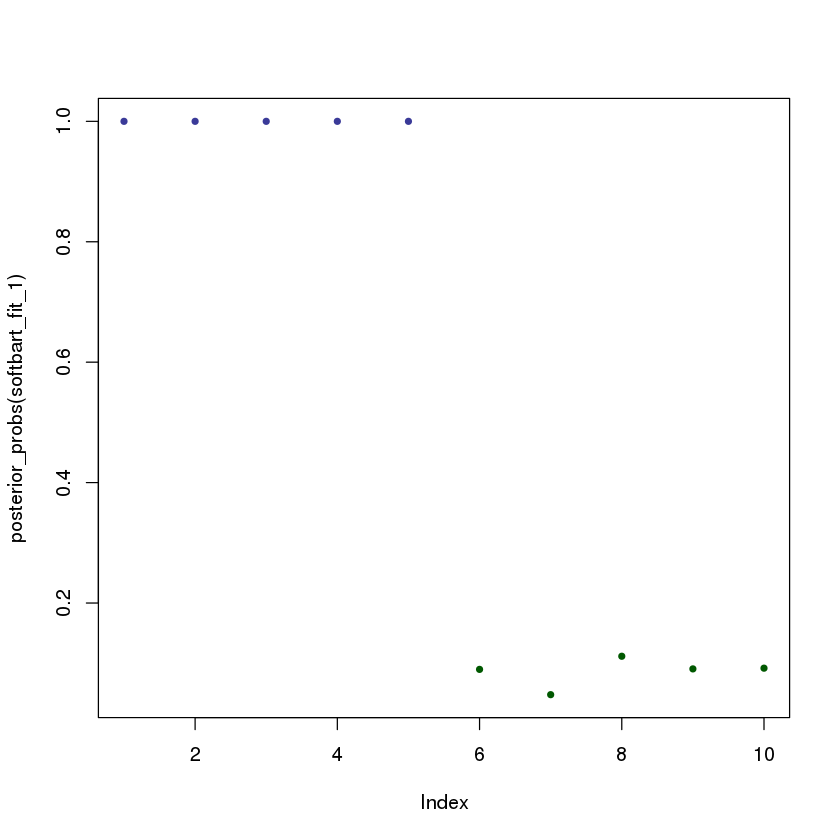

In [21]:
## Look at posterior model inclusion probabilities for each predictor. 

posterior_probs <- function(fit) colMeans(fit$var_counts > 0)
plot(posterior_probs(softbart_fit_1), 
     col = ifelse(posterior_probs(softbart_fit_1) > 0.5, muted("blue"), muted("green")), 
     pch = 20)

rmse <- function(x,y) sqrt(mean((x-y)^2))

In [22]:
rmse(softbart_fit_1$y_hat_train_mean, sim_data$Y)
rmse(softbart_fit_1$y_hat_test_mean, sim_data$Y_test)

[1] 0.8354627

[1] 1.124278

In [23]:
saveRDS(softbart_fit_1,file = "model_files/softbart_model_v2_20191126.RDS")

In [24]:
softbart_fit_1.read = readRDS("model_files/softbart_model_v2_20191126.RDS")
softbart_fit_1 <- softbart_fit_1.read